# Content based recommendation system

*Draft*

Video 1: https://www.youtube.com/watch?v=hOQg2LQM4ec&ab_channel=MiningMassiveDatasets \
Notes: 
- It would be interesting to mention the "long tail" phenomenom to explain why recommendation systems are interesting
- The key to recommendations is to have the utility matrix and predict the values that don't appear there

Video 2 (Content based): https://www.youtube.com/watch?v=IlqnNWuqToo&ab_channel=MiningMassiveDatasets \

- Main idea of content based: recommend items to customer x similar to previous items rated highly by x

- Plan of action: start with a user and find out a set of items the user likes using explicit and implicit data -> we are going to build an item profile -> Infer user profile -> Match -> Recommemd

1. For each item, create an item profile. Profile is a set of features. Convenient to think it as a vector
2. User profile: (weighted) average of rated item profiles

### Read the data

Useful features:
- artist_terms (tags)
- similar_artists?
- time_signature
- year
- artist_mbtags
- mode, _what is that?_

In [121]:
# Imports
import pickle
import pandas as pd
import os
import hdf5_getters as hdf5_getters
import numpy as np
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from zipfile import ZipFile
from io import BytesIO


In [97]:
# Read the songs dataset
with ZipFile('songs_cleaned.zip', 'r') as zipfile:
    data = zipfile.read('out.csv')

songs_cleaned = pd.read_csv(BytesIO(data))

In [98]:
# And pre-process the artist_terms feature

def ConvertStringtoList(string):
    s = string.replace('[','')
    s = s.replace(']','')
    s = s.replace('\'','')
    s = s.replace(' ','')
    li = list(s.split(","))
    return li

i = 0
for string in songs_cleaned['artist_terms']:
    list_ = ConvertStringtoList(string)
    songs_cleaned['artist_terms'][i] = list_
    i += 1

In [99]:
songs_cleaned.head()

,artist_id,song_id,artist_terms
0,ARMJAGH1187FB546F3,SOCIWDW12A8C13D406,"[blue-eyedsoul, poprock, blues-rock, beachmusi..."
1,ARXR32B1187FB57099,SOFSOCN12A8C143F5D,"[poppunk, skapunk, breakcore, alternativemetal..."
2,AR10USD1187B99F3F1,SOHKNRJ12A6701D1F8,"[post-hardcore, screamo, emo, hardcore, punkre..."
3,ARC43071187B990240,SOKEJEJ12A8C13E0D0,"[ccm, religiousmusic, losangeles, christianroc..."
4,ARL7K851187B99ACD2,SOMUYGI12AB0188633,"[bachata, merengue, reggaeton, latinpop, spani..."


In [100]:
with ZipFile('users_cleaned.zip', 'r') as zipfile:
    data = zipfile.read('out.csv')

users_cleaned = pd.read_csv(BytesIO(data))
print(len(users_cleaned))
users_cleaned.head()

697064


,userID,songID,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SODCXXY12AB0187452,2
2,b64cdd1a0bd907e5e00b39e345194768e330d652,SOLXDDC12A6701FBFD,1
3,b64cdd1a0bd907e5e00b39e345194768e330d652,SONQBUB12A6D4F8ED0,2
4,5a905f000fc1ff3df7ca807d57edb608863db05d,SOFKTPP12A8C1385CA,1


In [45]:
# Creating df with content terms for each songID
df = pd.DataFrame(songs_cleaned, columns=['song_id','artist_terms'])
df

,song_id,artist_terms
0,SOCIWDW12A8C13D406,"[blue-eyedsoul, poprock, blues-rock, beachmusi..."
1,SOFSOCN12A8C143F5D,"[poppunk, skapunk, breakcore, alternativemetal..."
2,SOHKNRJ12A6701D1F8,"[post-hardcore, screamo, emo, hardcore, punkre..."
3,SOKEJEJ12A8C13E0D0,"[ccm, religiousmusic, losangeles, christianroc..."
4,SOMUYGI12AB0188633,"[bachata, merengue, reggaeton, latinpop, spani..."
...,...,...
3190,SOILDRV12A8C13EB77,"[nowave, experimentalrock, instrumentalrock, d..."
3191,SOBUUYV12A58A7DA27,"[celtic, futurejazz, downtempo, easylistening,..."
3192,SOUWMIW12AB0184748,"[bluegrass, classiccountry, countrygospel, cou..."
3193,SOLXXPY12A67ADABA0,"[symphoblackmetal, blackmetal, heavymetal, dea..."


In [46]:
# extracting the artist_terms
all_terms = []
for row in range(len(df)):
    all_terms.append(df['artist_terms'][row])
    
all_terms = np.concatenate(all_terms)
all_terms = list(set(all_terms))

d = len(all_terms)

In [47]:
# Now, we intend to create a binary vector (length = d) that represents a song, 
# with 1s if the song has this term and 0s if it hasn't.

def vectorize(song):

    index = int(df.index[df['song_id'] == song][0])
    vector = np.zeros(len(all_terms))

    for i in range(len(vector)):
        if all_terms[i] in df['artist_terms'][index]:
            vector[i] = 1
            
    return vector


In [48]:
# Vectorize ALL the songs and save it into a dictionary

vector_representation = {}

for song in df['song_id']:
    vector_representation[song] = vectorize(song)
    
    
#vector_representation # we end up with a dictionary of songs with their vector representation

In order to find the optimal number of clusters for the K means clustering we run two different methods : 
- The Elbow Method 
- The Silhouette Method 

Inspiration from: 
- https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
- https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

In [49]:
# create a  dataframe of the vector representation of the song attributes
df = pd.DataFrame.from_dict(vector_representation,orient='index')
df

,0,1,2,3,4,5,6,7,8,9,...,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293
SOCIWDW12A8C13D406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOFSOCN12A8C143F5D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOHKNRJ12A6701D1F8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOKEJEJ12A8C13E0D0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
SOMUYGI12AB0188633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOILDRV12A8C13EB77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOBUUYV12A58A7DA27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOUWMIW12AB0184748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOLXXPY12A67ADABA0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Maximum number of clusters that we want to investigate in the Elbow method and the Silhuette method:
kmax = 50
K = range(1,kmax)

In [14]:
# Elbow Method
Sum_of_squared_distances = []
for k in K:
    print(k, end=",")
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    Sum_of_squared_distances.append(km.inertia_)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

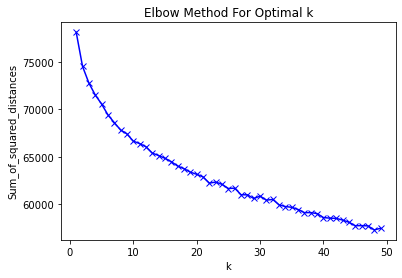

In [15]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [16]:
# Silhouette Method
sil = []
for k in range(2, kmax+1):
    print(k, end=",")
    kmeans = KMeans(n_clusters = k).fit(df.to_numpy())
    labels = kmeans.labels_
    sil.append(silhouette_score(df.to_numpy(), labels, metric = 'euclidean'))

2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,

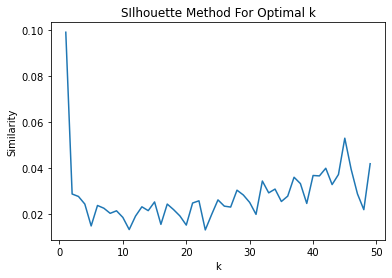

In [17]:
plt.plot(K,sil)
plt.xlabel('k')
plt.ylabel('Similarity')
plt.title('Silhouette Method For Optimal k')
plt.show()

The elbow method never convergers towards a specific sum of sq distance, meaning that clustering of this data does not help in identifying the value of the attributes. Looking at the data set with 3500 columns and only 10000 rows this makes sense. In order to simplify and improve the clustering we will clean the data in order to make a better recommendation system. 

Number of terms that appear less than a 50 times are = 1967


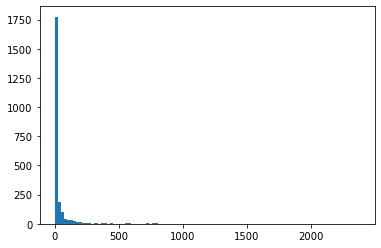

,10,12,26,32,42,46,48,56,59,71,...,2235,2238,2250,2260,2275,2280,2282,2284,2287,2290
SOCIWDW12A8C13D406,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
SOFSOCN12A8C143F5D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOHKNRJ12A6701D1F8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOKEJEJ12A8C13E0D0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOMUYGI12AB0188633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# cleaning infrequent features:
a = 50
print("Number of terms that appear less than a", a, "times are =",sum(df.sum() <= a))
test = df.sum().sort_values()
plt.hist(test, bins=100)
plt.show()

# These infequently used terms will be sorted out in order to simplify the clustering and to improve the recommendation system
df_subset = df.loc[:,df.sum() >= a]
df_subset.head()
# other options for cleaning the data:
# - outlier detection
# - correlations of attributes can create bias and could be removed

In [24]:
kmax=50
K = range(1,kmax)

In [25]:
Sum_of_squared_distances = []
for k in K:
    print(k, end=",")
    km = KMeans(n_clusters=k)
    km = km.fit(df_subset)
    Sum_of_squared_distances.append(km.inertia_)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

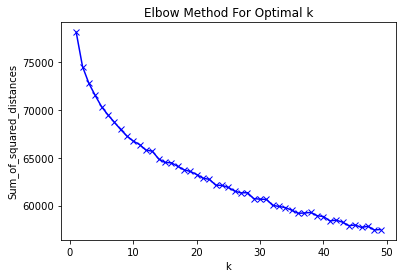

In [26]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [27]:
sil = []

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    print(k, end=",")
    kmeans = KMeans(n_clusters = k).fit(df_subset.to_numpy())
    labels = kmeans.labels_
    sil.append(silhouette_score(df.to_numpy(), labels, metric = 'euclidean'))

2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,

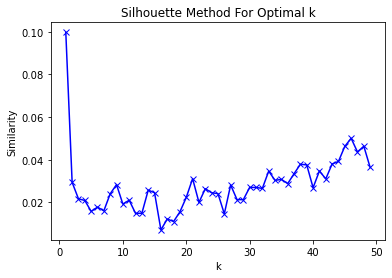

In [30]:
plt.plot(K,sil,"bx-")
plt.xlabel('k')
plt.ylabel('Similarity')
plt.title('Silhouette Method For Optimal k')
plt.show()

We see that according to the Elbow method still does not converge towards any optimal K, but according to the Silhouette method we see a slight peak around 46 as a local maximum. There might be better solutions for optimal K larger than 50, but the computation and time-scope limitations resulted in us choosing 46 as the number of clusters. 
Cleaning the infrequent items helped, especially in the silhouette method, to create a more define graph.
Now that the optimal number of clusters have been found we will continue with the k-means cluster analysis.

In [106]:
optimal_k = 46

In [107]:
# K-means clustering
kmeans = KMeans(n_clusters=optimal_k).fit(df_subset)
centroids = kmeans.cluster_centers_

We have now found our cluster centroids and saved these. In order to create recommendations for users we need to categorize the songs and have the list of relevant songs ready in order to create fast recommendations. Euclidean distance was chosen as the similarity measure and the purpose is find the cluster centroid closest to song and 

In [139]:
# Euclidean distance 
def euclidean_distance(a, b):
    dist = np.linalg.norm(a-b)
    return dist

In [140]:
# Creating df with each song
# Similarities matrix
similarities = np.zeros((len(df_subset),len(centroids)))
i = 0
for song in df_subset.index:
    j = 0
    for centroid in range(1,optimal_k):
        dist = euclidean_distance(df_subset.loc[song].to_numpy(),centroids[centroid])
        similarities[i,j] = dist
        j += 1
    i += 1

In [141]:
similarities

array([[5.54369411, 5.7340541 , 5.84383974, ..., 5.23533482, 5.68773046,
        0.        ],
       [6.1589402 , 5.74206674, 4.6530058 , ..., 5.79555916, 5.74603728,
        0.        ],
       [4.47835029, 3.95158305, 4.60198226, ..., 3.39206559, 4.30700334,
        0.        ],
       ...,
       [3.88015738, 3.47653174, 4.59291927, ..., 2.19731798, 3.9391553 ,
        0.        ],
       [5.65497111, 5.32992608, 6.05396258, ..., 4.90017621, 5.33700395,
        0.        ],
       [5.3430262 , 5.18453242, 4.70937796, ..., 4.54693834, 5.31823383,
        0.        ]])

In [187]:
# Creating df with each song and what specific cluster the song belongs to
cluster_matrix = np.zeros((len(df_subset),len(centroids)))
i = 0
for song in df_subset.index:
    #print(song)
    min_dist = 999999
    closest_centroid = -1
    for centroid_no in range(0,optimal_k):
        dist = euclidean_distance(df_subset.loc[song],centroids[centroid_no])
        #print(centroid_no, dist)
        if dist < min_dist:
            #print("min_dist update to",dist)
            min_dist = dist
            closest_centroid = centroid_no
    cluster_matrix[i,closest_centroid] = 1
    i += 1

In [188]:
cluster_df = pd.DataFrame(cluster_matrix, columns = range(0,optimal_k), index = df_subset.index)
cluster_df.sum().sum()

3195.0

### Recommendations based on Clustering
We are going to base a recommendation system in the similatiry of the centroid of each cluster with the user profile. In this way we would recommend songs that are similar in taste with the users without measuring similarity between every song and the user profile. Thus simplifying the computations.  

In [115]:
# Get user profile for all users

def getUserProfile(user):

    song_counts = list(user_plays[user_plays['userID'] == user]['play_count'])
    song_list = list(user_plays[user_plays['userID'] == user]['songID'])


    # Check if the user songs are in the song dataset and get the indices of the songs
    indices = []
    for song in song_list:
        if song in list(df_songs['song_id']):
            indices.append(song_list.index(song))
        else:
            continue


    # Get the User profile (i.e. Compute the (weighted) average of the songs of a user)
    a = [song_counts[i] for i in indices]
    b = [vector_representation[song_list[i]] for i in indices]

    numerator = np.zeros(d)
    for i in range(len(a)):
        numerator = numerator + ( a[i] * np.asarray(b[i]) )

    user_profile = numerator / sum(a)
    return user_profile

user = '5a905f000fc1ff3df7ca807d57edb608863db05d'
user_profile = getUserProfile(user)
user_profile

array([0., 0., 0., ..., 0., 0., 0.])

In [135]:
# find relevant subset based on prvious cleaning
user_profile_subset = user_profile[df_subset.columns]

Now when we have an example of a user profile we find the cluster that this user profile is closest related to. Based on that we can find a playlist of songs within the same cluster and this could be a first recommendation for the user.

In [218]:
# finding closest cluster centroid to the user profile
min_dist = 99999
user_closest_centroid = -1
for centroid_no in range(0,optimal_k):
    dist = euclidean_distance(user_profile_subset,centroids[centroid_no])
    if dist < min_dist:
        min_dist = dist
        user_closest_centroid = centroid_no
user_closest_centroid

23

In [194]:
# Finding recommended playlist for user:
recommended_playlist = cluster_df.index[cluster_df[23] == 1]
print(recommended_playlist)

Index(['SOVXMTN12A8C135A18', 'SOTUNMH12A6D4FA3E6', 'SOJEVZW12A8C133988',
       'SOFSKON12A8C13B3B5', 'SOFRROW12A6701CBEA', 'SORERTC12A8AE454B3',
       'SOAECHX12A6D4FC3D9', 'SOITFPA12A670201C6', 'SOBUIHY12A6D4F5D1B',
       'SOKBTBD12A6D4FA3C6',
       ...
       'SOHHJYE12A8AE47599', 'SORUEDG12A8C13CFEF', 'SOCWZCV12A58A7AB87',
       'SOTMVUQ12A6BD53721', 'SOFHZSP12A58A79004', 'SOJNQAS12A8C134963',
       'SOKFFSS12A8C1316E3', 'SOEILXI12AB017CBA6', 'SOFRBZI12AB0186AE8',
       'SOILDRV12A8C13EB77'],
      dtype='object', length=115)


If we want to speficify the next 10 songs for the user we need to find the closest song to the user profile within in the cluster.

In [230]:
# list of terms for songs in cluster
# user profile

score_dict = {}

for song in recommended_playlist:
    #print("song:",song)
    song_vector = df_subset[df_subset.index == song].to_numpy()
    score_dict[song] = euclidean_distance(user_profile_subset,song_vector)


In [232]:
scores_l = sorted(score_dict.items(), key=lambda x:x[1])
scores_dict = dict(scores_l)
ids = list(score_dict.keys())
scores = list(score_dict.values())
# R best recommendations
R = 10
recommended_songs = ids[0:R]

# Print results
for i in range(R):
    print('Song:', recommended_songs[i], 'with score:', f'{scores[i]:.3f}' )

Song: SOVXMTN12A8C135A18 with score: 5.077
Song: SOTUNMH12A6D4FA3E6 with score: 5.426
Song: SOJEVZW12A8C133988 with score: 4.978
Song: SOFSKON12A8C13B3B5 with score: 4.667
Song: SOFRROW12A6701CBEA with score: 5.696
Song: SORERTC12A8AE454B3 with score: 5.667
Song: SOAECHX12A6D4FC3D9 with score: 3.972
Song: SOITFPA12A670201C6 with score: 4.256
Song: SOBUIHY12A6D4F5D1B with score: 5.142
Song: SOKBTBD12A6D4FA3C6 with score: 5.426
